## Import libraries

In [1]:
## Import libraries
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler

import sys
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'
sys.path.append('/Users/riccardo/Documents/GitHub/COVID19Classification/')

from Modules import Parameters, DataPreprocessing as DP, Classification as CL, CustomFunctions as CF

3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]


## Parameters

In [2]:
## Multivariate sets
FC_set = Parameters.FC_set
Dem_set = Parameters.Dem_set
CK_set = Parameters.CK_set
BM_set =  Parameters.BM_set

## Targets
target_train = Parameters.train_target
target_test = Parameters.test_target

## Age
lower_bound = Parameters.age_min
upper_bound = Parameters.age_max

## Delta onset
lower_bound_donset = Parameters.donset_min
upper_bound_donset = Parameters.donset_max

## Minimum NPV
min_NPV_Models = Parameters.min_NPV_Models
min_NPV = Parameters.min_NPV

## Correlation threshod
corr_th_univ = Parameters.corr_th_univ

## Min % no nans per column
perc_nonans = Parameters.perc_nonans
perc_nonans_univ = Parameters.perc_nonans_univ

## Nan masking row-wise
do_nan_masking = Parameters.do_nan_masking
do_nan_masking_univ = Parameters.do_nan_masking_univ
nan_masking = Parameters.nan_masking
do_nan_masking_groupwise = Parameters.do_nan_masking_groupwise

## Reference time
ref_time = Parameters.ref_time

## N samples for average
N_av = Parameters.N_av

## Imputation
imputation_method = Parameters.imputation_method
imputation_method_univ = Parameters.imputation_method_univ

## Standardization
std_method = Parameters.std_method
std_cat_variables = Parameters.std_cat_variables

## PCA % var. threshold
pc_var_th = Parameters.pca_var_threshold

## Train-test
test_size = Parameters.test_size
ignore_sex = Parameters.ignore_sex

## Plot
plot_minNPV_models = Parameters.plot_minNPV_models

## Feature selection
use_manual_selection = Parameters.use_manual_selection

## Paths
path_datasets = Parameters.path_datasets
path_results = Parameters.path_results
path_figures = Parameters.path_figures
path_setsdescription = Parameters.path_setsdescription
exp_description = Parameters.exp_description
exp_univ_description = Parameters.exp_univ_description
exp_multiv_description = Parameters.exp_multiv_description
foldername_univ = Parameters.foldername_univ
foldername_multiv = Parameters.foldername_multiv

## Dataset
use_CCIMasked_dataset = Parameters.use_CCIMasked_dataset

## Regulariser
find_regulariser_before_average = Parameters.find_regulariser_before_average

## Run experiments
run_experiments = True

## Import and prepare datasets

In [3]:
DataInpatients, DataOutpatients = DP.data_preprocessing()

# Mask data by target
mask = pd.notnull(DataInpatients[target_train].values) & pd.notnull(DataInpatients[target_test].values)
DataInpatients = DataInpatients.loc[mask,:]

## Models dictionary

In [4]:
models_dict = {}

## LR models
models_dict['LR'] = {}
models_dict['LR']['FC'] = FC_set
models_dict['LR']['FC+Dem'] = FC_set + Dem_set
models_dict['LR']['CK'] = CK_set
models_dict['LR']['CK+Dem'] = CK_set + Dem_set
models_dict['LR']['BM'] = BM_set
models_dict['LR']['BM+Dem'] = BM_set + Dem_set

## Datasets description

In [5]:
nan_masking_val = 0.5
do_nan_masking_groupwise_val = True
groups = [FC_set, CK_set, Dem_set, BM_set]

dict_stats = { 'N': [], 'NANs': [], 'sex': [], 'age': [], 'd. onset': [], 'CCI<3': [], 'OTI+death': []}

for model_name in models_dict['LR'].keys():
    print(model_name)
    
    # Mask data
    Data = DataInpatients.copy()
    _, row_mask = CL.nan_masking_fc(Data, models_dict['LR'][model_name], 
                                    nan_masking=nan_masking_val, 
                                    do_nan_masking_groupwise=do_nan_masking_groupwise_val, 
                                    groups=groups, 
                                    return_row_mask=True)

    # N. patients
    n_patients = sum(row_mask)
    val_str = '%d' % n_patients
    #print('N: '+val_str)
    dict_stats['N'].append(val_str)

    # NANs
    n = DataInpatients.loc[row_mask, models_dict['LR'][model_name]].size
    n_nan = sum(DataInpatients.loc[row_mask, models_dict['LR'][model_name]].isna().values.flatten())
    ratio = n_nan/n*100
    val_str = '%.1f%%' % ratio
    #print('NANs: '+val_str)
    dict_stats['NANs'].append(val_str)
    
    # Sex
    n = sum(DataInpatients.loc[row_mask, 'sex'] == 1)
    ratio = n/n_patients*100
    val_str = '%d(%.1f%%)' %(n, ratio)
    #print('sex: '+val_str)
    dict_stats['sex'].append(val_str)

    # Age
    q1, median, q3 = DataInpatients.loc[row_mask, 'age'].quantile([0.25,0.5,0.75])
    val_str = '%d(%d-%d)' % (round(median), round(q1), round(q3))
    #print('age: '+val_str)
    dict_stats['age'].append(val_str)

    # D. onset
    q1, median, q3 = DataInpatients.loc[row_mask, 'delta_onset'].quantile([0.25,0.5,0.75])
    val_str = '%d(%d-%d)' % (round(median), round(q1), round(q3))
    #print('d. onset: '+val_str)
    dict_stats['d. onset'].append(val_str)

    # CCI
    n = sum(DataInpatients.loc[row_mask, 'CCI (charlson comorbidity index)'] < 3)
    ratio = n/n_patients*100
    val_str = '%d(%.1f%%)' %(n, ratio)
    #print('CCI<2: '+val_str)
    dict_stats['CCI<3'].append(val_str)

    # Outcome
    n = sum(DataInpatients.loc[row_mask, 'IOT+death'] == 1)
    ratio = n/n_patients*100
    val_str = '%d(%.1f%%)' %(n, ratio)
    #print('CCI<2: '+val_str)
    dict_stats['OTI+death'].append(val_str)

    #print('\n')

df_stat = pd.DataFrame(dict_stats, index=models_dict['LR'].keys())

# Export table
filename = 'DatasetsDescription'+exp_description+'.xlsx'
df_stat.to_excel(path_setsdescription+filename)

df_stat


FC
FC+Dem
CK
CK+Dem
BM
BM+Dem


,N,NANs,sex,age,d. onset,CCI<3,OTI+death
FC,655,1.3%,206(31.5%),68(59-76),9(7-12),264(40.3%),160(24.4%)
FC+Dem,655,0.9%,206(31.5%),68(59-76),9(7-12),264(40.3%),160(24.4%)
CK,261,1.0%,84(32.2%),66(56-76),9(7-12),112(42.9%),61(23.4%)
CK+Dem,261,0.7%,84(32.2%),66(56-76),9(7-12),112(42.9%),61(23.4%)
BM,483,7.0%,165(34.2%),67(58-76),9(7-12),203(42.0%),96(19.9%)
BM+Dem,483,3.6%,165(34.2%),67(58-76),9(7-12),203(42.0%),96(19.9%)


## Run analysis - multiple splits

In [6]:
if run_experiments:
    Data = DataInpatients.copy()     
    
    ## Initialize results dictionaries
    Results_N_av = {}
    Ground_Truth_N_av = {}
    for model in models_dict.keys():
        Results_N_av[model] = {}
        Ground_Truth_N_av[model] = {}
        for set_name in models_dict[model].keys():
            Results_N_av[model][set_name] = {'Train':[], 'Test':[], 'Train_value': [], 'Test_value': [], 'Weights':[], 'Bias':[], 'C':[], 'Std_Parameters': []}
            Ground_Truth_N_av[model][set_name] = {'Train':[], 'Test':[]}
            if min_NPV_Models:
                Results_N_av[model][set_name+'_minNPV'] = {'Train':[], 'Test':[], 'Train_value': [], 'Test_value': []}
                Ground_Truth_N_av[model][set_name+'_minNPV'] = {'Train':[], 'Test':[]}
    
    do_statistic_misclassified = True
    if do_statistic_misclassified:
        positives = Data.loc[Data[target_test].values==1, 'ID'].values
        negatives = Data.loc[Data[target_test].values==0, 'ID'].values
        Negatives_N_av = {}
        False_positives_N_av = {}
        Positives_N_av = {}
        False_negatives_N_av = {}
        for model in models_dict.keys():
            model_set_names = models_dict[model].keys()
            Negatives_N_av[model] = pd.DataFrame(np.zeros((len(negatives), len(model_set_names))), index=negatives, columns=model_set_names)
            False_positives_N_av[model]= pd.DataFrame(np.zeros((len(negatives), len(model_set_names))), index=negatives, columns=model_set_names)
            Positives_N_av[model] = pd.DataFrame(np.zeros((len(positives), len(model_set_names))), index=positives, columns=model_set_names)
            False_negatives_N_av[model] = pd.DataFrame(np.zeros((len(positives), len(model_set_names))), index=positives, columns=model_set_names)
            

    ## Sets of variables for nan removal
    groups = [FC_set, CK_set, Dem_set, BM_set]


    ## Run average
    fix_outliers = False
    do_imputation = True
    print('Running average...')
    print('Fix outliers: %s' % fix_outliers)
    print('Do imputation: %s' % do_imputation)
    print('Nan masking groupwise: %s' % do_nan_masking_groupwise)
    for i_split in range(N_av): 
        print('%d/%d' %(i_split+1, N_av))
        
        Results = CL.models_prediction(Data=Data.copy(),
                                       test_size=test_size,
                                       models_dict=models_dict,
                                       target_train=target_train, 
                                       target_test=target_test, 
                                       min_NPV=min_NPV,
                                       min_NPV_Models=min_NPV_Models,
                                       standardization=std_method, 
                                       imputation=imputation_method, 
                                       do_nan_masking=do_nan_masking,
                                       do_nan_masking_univ=do_nan_masking_univ,
                                       nan_masking=nan_masking, 
                                       do_nan_masking_groupwise=do_nan_masking_groupwise, 
                                       groups=groups,
                                       do_preprocessing=True, 
                                       fix_outliers=fix_outliers,
                                       do_imputation=do_imputation, 
                                       ignore_sex=ignore_sex, 
                                       std_cat_variables=std_cat_variables)

        for model in Results_N_av.keys():
            for set_name in Results_N_av[model].keys():
                Ground_Truth_N_av[model][set_name]['Train'].append(Results[model][set_name]['Train_Labels'])
                Ground_Truth_N_av[model][set_name]['Test'].append(Results[model][set_name]['Test_Labels'])
                Results_N_av[model][set_name]['Train_value'].append(Results[model][set_name]['Train_value'])
                Results_N_av[model][set_name]['Test_value'].append(Results[model][set_name]['Test_value'])
                Results_N_av[model][set_name]['Train'].append(Results[model][set_name]['Train'])
                Results_N_av[model][set_name]['Test'].append(Results[model][set_name]['Test'])
                
                if model=='LR' and '_minNPV' not in set_name:
                    Results_N_av[model][set_name]['Weights'].append(Results[model][set_name]['Weights'])
                    Results_N_av[model][set_name]['Bias'].append(Results[model][set_name]['Bias'])
                    Results_N_av[model][set_name]['C'].append(Results[model][set_name]['C'])
                    Results_N_av[model][set_name]['Std_Parameters'].append(Results[model][set_name]['Std_Parameters'])
                        
                if do_statistic_misclassified and '_minNPV' not in set_name:
                    ID_test = Results[model][set_name]['ID_test']
                    labels_test = Results[model][set_name]['Test_Labels']
                    pred_test = Results[model][set_name]['Test']
                    
                    mask_positives = labels_test==1
                    ID_positives = ID_test[mask_positives]
                    Positives_N_av[model].loc[ID_positives, [set_name]] +=1
                    mask_false_negatives = mask_positives & (pred_test==0)
                    ID_false_negatives = ID_test[mask_false_negatives]
                    False_negatives_N_av[model].loc[ID_false_negatives, [set_name]] +=1

                    mask_negatives = labels_test==0
                    ID_negatives = ID_test[mask_negatives]
                    Negatives_N_av[model].loc[ID_negatives, [set_name]] +=1
                    mask_false_positives = mask_negatives & (pred_test==1)
                    ID_false_positives = ID_test[mask_false_positives]
                    False_positives_N_av[model].loc[ID_false_positives, [set_name]] +=1

Running average...
Fix outliers: False
Do imputation: True
Nan masking groupwise: True
1/100
2/100
3/100
4/100
5/100
6/100
7/100
8/100
9/100
10/100
11/100
12/100
13/100
14/100
15/100
16/100
17/100
18/100
19/100
20/100
21/100
22/100
23/100
24/100
25/100
26/100
27/100
28/100
29/100
30/100
31/100
32/100
33/100
34/100
35/100
36/100
37/100
38/100
39/100
40/100
41/100
42/100
43/100
44/100
45/100
46/100
47/100
48/100
49/100
50/100
51/100
52/100
53/100
54/100
55/100
56/100
57/100
58/100
59/100
60/100
61/100
62/100
63/100
64/100
65/100
66/100
67/100
68/100
69/100
70/100
71/100
72/100
73/100
74/100
75/100
76/100
77/100
78/100
79/100
80/100
81/100
82/100
83/100
84/100
85/100
86/100
87/100
88/100
89/100
90/100
91/100
92/100
93/100
94/100
95/100
96/100
97/100
98/100
99/100
100/100


### Parameters dictionary

In [7]:
if run_experiments:
    parameters_dict = {}
    std_parameters_dict = {}

    if 'LR' in Results_N_av.keys():
        parameters_dict['LR'] = {}
        std_parameters_dict['LR'] = {}

        for set_name in Results_N_av['LR'].keys():
            if '_minNPV' not in set_name:
                weights = np.array(Results_N_av['LR'][set_name]['Weights'])
                bias = np.array(Results_N_av['LR'][set_name]['Bias'])
                C_reg = np.array(Results_N_av['LR'][set_name]['C'])
                Std_Parameters = np.array(Results_N_av['LR'][set_name]['Std_Parameters'])

                if weights.shape[1]>1:
                    column_names = models_dict['LR'][set_name]
                    if '#Dis' in set_name:
                        new_columns = []
                        bool_idx = []
                        for col in column_names:
                            v = [col1 for col1 in Data.columns if col+'_INT' in col1]
                            new_columns += v
                            if len(v)>0:
                                bool_idx += [False]
                            else:
                                bool_idx += [True]
                        new_columns += list(np.array(column_names)[bool_idx])
                        column_names = new_columns
                    df = pd.DataFrame(weights, columns=column_names)
                    df.insert(loc=0, column='bias', value=bias)
                    parameters_dict['LR'][set_name] = df

                    column_names = models_dict['LR'][set_name]
                    if '#Dis' not in set_name:
                        df = pd.DataFrame(Std_Parameters, columns=[col for col in column_names if col!='sex'])
                        df.insert(loc=0, column='C', value=C_reg)
                    else:
                        df = pd.DataFrame(C_reg, columns=['C'])
                    std_parameters_dict['LR'][set_name] = df

### Compute performanes

In [8]:
if run_experiments:

    Performances = {}

    Scores = {'roc_auc_score': roc_auc_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'NPV': precision_score,
              'specificity': recall_score,
              'accuracy': accuracy_score}

    for model in Results_N_av.keys():
        Performances[model] = {}

        for set_name in Results_N_av[model].keys():
            #print(model, set_name)
            Performances[model][set_name] = {}
            print(model, set_name)

            for score in Scores.keys():
                Performances[model][set_name][score] = {'Train': [], 'Test': []}
                sc = Scores[score]
                for sample in range(N_av):
                    y_pred_train = Results_N_av[model][set_name]['Train'][sample]
                    y_value_train = Results_N_av[model][set_name]['Train_value'][sample]
                    y_train = Ground_Truth_N_av[model][set_name]['Train'][sample]
                    y_pred_test = Results_N_av[model][set_name]['Test'][sample]
                    y_value_test = Results_N_av[model][set_name]['Test_value'][sample]
                    y_test = Ground_Truth_N_av[model][set_name]['Test'][sample]

                    y_pred_train_1 = 1 - y_pred_train
                    y_train_1 = 1 - y_train
                    y_pred_test_1 = 1 - y_pred_test
                    y_test_1 = 1 - y_test

                    if score in ['NPV', 'specificity']:
                        if sum(pd.notnull(y_pred_train_1))>1:
                            score_val_train = sc(y_train_1, y_pred_train_1)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test_1))>1:
                            score_val_test = sc(y_test_1, y_pred_test_1)
                        else:
                            score_val_test = np.nan
                    elif score=='roc_auc_score':
                        if sum(pd.notnull(y_pred_train))>1:
                            score_val_train = sc(y_train, y_value_train)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test))>1:
                            score_val_test = sc(y_test, y_value_test)
                        else:
                            score_val_test = np.nan
                    else:
                        if sum(pd.notnull(y_pred_train))>1:
                            score_val_train = sc(y_train, y_pred_train)
                        else:
                            score_val_train = np.nan

                        if sum(pd.notnull(y_pred_test_1))>1:
                            score_val_test = sc(y_test, y_pred_test)
                        else:
                            score_val_test = np.nan

                    Performances[model][set_name][score]['Train'].append(score_val_train)
                    Performances[model][set_name][score]['Test'].append(score_val_test)

LR FC
LR FC_minNPV
LR FC+Dem
LR FC+Dem_minNPV
LR CK
LR CK_minNPV
LR CK+Dem
LR CK+Dem_minNPV
LR BM
LR BM_minNPV
LR BM+Dem
LR BM+Dem_minNPV


#### Average Performances

In [9]:
if run_experiments:
    ## Mean performances
    Performances_mean_err_train = {}
    Performances_mean_err_train_0 = {}

    test_or_train = 'Train'

    for score in Scores:
        Performances_mean_err_train[score] = {'Mean':[], 'Err':[]}
        Performances_mean_err_train_0[score] = {'Mean':[], 'Err':[]}

    for model in Performances.keys():
        for set_name in Performances[model].keys():
            for score in Performances[model][set_name].keys():

                if 'minNPV' in set_name:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_train_0[score]['Mean'].append(score_mean)
                    Performances_mean_err_train_0[score]['Err'].append(score_err)

                else:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_train[score]['Mean'].append(score_mean)
                    Performances_mean_err_train[score]['Err'].append(score_err)



    Performances_mean_err_test = {}
    Performances_mean_err_test_0 = {}

    test_or_train = 'Test'

    for score in Scores:
        Performances_mean_err_test[score] = {'Mean':[], 'Err':[]}
        Performances_mean_err_test_0[score] = {'Mean':[], 'Err':[]}

    for model in Performances.keys():
        for set_name in Performances[model].keys():
            for score in Performances[model][set_name].keys():

                if 'minNPV' in set_name:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_test_0[score]['Mean'].append(score_mean)
                    Performances_mean_err_test_0[score]['Err'].append(score_err)

                else:
                    v = np.array(Performances[model][set_name][score][test_or_train])
                    mask = pd.notnull(v)
                    if sum(mask)>0.5*len(mask):
                        v = v[pd.notnull(v)]
                        ci = st.t.interval(alpha=0.95, df=len(v)-1, loc=np.mean(v), scale=st.sem(v))
                        score_mean = np.mean(ci)
                        score_err = (ci[1] - ci[0])/2.
                    else:
                        score_mean = 0
                        score_err = 0

                    Performances_mean_err_test[score]['Mean'].append(score_mean)
                    Performances_mean_err_test[score]['Err'].append(score_err)


### Export results

In [10]:
if run_experiments:
    # Create directory
    try:
        os.mkdir(path_results+foldername_multiv)
    except OSError:
        print ("Creation of the directory failed")
    else:
        print ("Successfully created the directory")

    path_export = path_results+foldername_multiv

    # Export 

    # Tuples here are: (name_score, mean) (name_score, err) #
    my_tuples = [(score, val) for score in Scores for val in ['Mean', 'Err']]
    new_columns = pd.MultiIndex.from_tuples(my_tuples)
    index = []
    for model in models_dict.keys():
        index.extend([model+': '+name for name in models_dict[model].keys()])
    n_models = len(index)
    values = np.array([np.array(Performances_mean_err_train[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
    df_results = pd.DataFrame(values, columns=new_columns, index=index)
    filename = 'performances_train.xlsx'
    df_results.to_excel(path_export+filename, engine='xlsxwriter')

    if min_NPV_Models:
        values_0 = np.array([np.array(Performances_mean_err_train_0[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
        df_results_0 = pd.DataFrame(values_0, columns=new_columns, index=index)
        filename_0 = 'performances_minNPV_train.xlsx'
        df_results_0.to_excel(path_export+filename_0, engine='xlsxwriter')


    # Tuples here are: (name_score, mean) (name_score, err) #
    values = np.array([np.array(Performances_mean_err_test[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
    df_results = pd.DataFrame(values, columns=new_columns, index=index)
    filename = 'performances_test.xlsx'
    df_results.to_excel(path_export+filename, engine='xlsxwriter')

    if min_NPV_Models:
        values_0 = np.array([np.array(Performances_mean_err_test_0[score][val]) for score in Scores for val in ['Mean', 'Err']]).transpose()
        df_results_0 = pd.DataFrame(values_0, columns=new_columns, index=index)
        filename_0 = 'performances_minNPV_test.xlsx'
        df_results_0.to_excel(path_export+filename_0, engine='xlsxwriter')

Creation of the directory failed


In [11]:
if run_experiments:
    # Export models description
    models_description = {}
    for model in models_dict.keys():
        for name in models_dict[model].keys():
            description = ' # '.join(models_dict[model][name])
            models_description[model+'#'+name] = description

    filename = 'models_description.xlsx'
    pd.Series(models_description).to_excel(path_export+filename)


    # Export models parameters
    for set_name in parameters_dict['LR'].keys():
        df = parameters_dict['LR'][set_name]
        filename = 'Parameters_model#%s_name#%s.xlsx' % ('LR', set_name)
        df.to_excel(path_export+filename)


    # Export models std parameters
    for set_name in std_parameters_dict['LR'].keys():
        df = std_parameters_dict['LR'][set_name]
        filename = 'StdParameters_model#%s_name#%s.xlsx' % ('LR', set_name)
        df.to_excel(path_export+filename)
        
        
    # Export misclassifications
    '''
    for model in models_dict['LR'].keys():
        df_negatives = Negatives_N_av[model]
        filename = 'Negatives_model#%s.xlsx' % model
        df_negatives.to_excel(path_export+filename)
        df_false_positives = False_positives_N_av[model]
        filename = 'FalsePositives_model#%s.xlsx' % model
        df_false_positives.to_excel(path_export+filename)
        #
        df_positives = Positives_N_av[model]
        filename = 'Positives_model#%s.xlsx' % model
        df_positives.to_excel(path_export+filename)
        df_false_negatives = False_negatives_N_av[model]
        filename = 'FalseNegatives_model#%s.xlsx' % model
        df_false_negatives.to_excel(path_export+filename)
    '''

## Figures

In [20]:
# Colors
green = '#7FB285'
violet = '#A888BF'
light_red_purp = '#FF616D'
red_purp = '#F73B5C'
light_blue = '#3C8DAD'
dark_blue = '#125D98'
orange = '#F5A962'
lavander = '#D5C6E0'
dark_liver = '#56494C'
electricblue = '#7DF9FF'
grey_1 = '#AAAAAA'
grey_2 = '#DDDDDD'

# Color scheme
color_0 = dark_blue
color_1 = red_purp
color_control = green

# Parameters
fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

### 2D Plot - test outpatients

In [15]:
model_name = 'BM+Dem' 

Data_train = DataInpatients.copy()
Data_test = DataOutpatients.copy() # Data_Control
if 'FC' not in model_name:
    Data_test = DataInpatients.copy() 
    
print(Data_train.shape, Data_test.shape)

(319, 38) (319, 38)


In [16]:
random_state = None
columns = models_dict['LR'][model_name]
fix_outliers = False
do_imputation = True
groups = [FC_set, CK_set, Dem_set, BM_set]
#columns = list(np.random.permutation(columns))

results, MLR, prep_data = CL.LR_model_results(Data=Data_train,
                                              Data_test=Data_test,
                                              features=columns, 
                                              set_name=model_name, 
                                              target_train=target_train, 
                                              target_test=target_test, 
                                              test_size=test_size,
                                              hyperp_dict={}, 
                                              do_preprocessing=True, 
                                              fix_outliers=fix_outliers, 
                                              do_imputation=do_imputation, 
                                              imputation=imputation_method, 
                                              pca_var_threshold=pc_var_th, 
                                              standardization=std_method, 
                                              min_NPV_Models=min_NPV_Models,
                                              min_NPV=min_NPV, 
                                              groups=groups, 
                                              do_nan_masking=do_nan_masking, 
                                              do_nan_masking_groupwise=do_nan_masking_groupwise, 
                                              do_nan_masking_univ=do_nan_masking_univ, 
                                              nan_masking=nan_masking,
                                              return_model=True, 
                                              return_data=True)

In [17]:
# Prepare data for 2D plot
Data_X = prep_data['Train']
Data_y = results[model_name]['Train_Labels']
Data_X_t = prep_data['Test']
proj_2D = CF.MLR_axis(MLR, Data_X, Data_test=Data_X_t, use_bias=False) # use_bias=False
X2D_train = proj_2D['Train']
X2D_test = proj_2D['Test']
X1D_mlr_train, X1D_pca_train = X2D_train[:, 0], X2D_train[:, 1]
X1D_mlr_test, X1D_pca_test = X2D_test[:, 0], X2D_test[:, 1]
X_1, X_2 = X1D_mlr_train, X1D_pca_train
X_1_0 = X_1[Data_y==0].copy()
X_2_0 = X_2[Data_y==0].copy()
X_1_1 = X_1[Data_y==1].copy()
X_2_1 = X_2[Data_y==1].copy()
X_1_t, X_2_t = X1D_mlr_test.copy(), X1D_pca_test.copy()

## Define grid
h = .05 # .02  # step size in the mesh
pref_lims = 0.2
offset_lims = 0.
x_1_min, x_1_max = X_1.min() - pref_lims*(X_1.max()-X_1.min()), X_1.max() + pref_lims*(X_1.max()-X_1.min())
x_2_min, x_2_max = X_2.min() - pref_lims*(X_2.max()-X_2.min()), X_2.max() + pref_lims*(X_2.max()-X_2.min())
X_1_t, X_2_t = X1D_mlr_test, X1D_pca_test
x_1_min_t, x_1_max_t = X_1_t.min() - pref_lims*(X_1_t.max()-X_1_t.min()), X_1_t.max() + pref_lims*(X_1_t.max()-X_1_t.min())
x_2_min_t, x_2_max_t = X_2_t.min() - pref_lims*(X_2_t.max()-X_2_t.min()), X_2_t.max() + pref_lims*(X_2_t.max()-X_2_t.min())
if x_1_min_t<x_1_min:
    x_1_min = x_1_min_t
if x_2_min_t<x_2_min:
    x_2_min = x_2_min_t
if x_1_max_t>x_1_max:
    x_1_max = x_1_max_t
if x_2_max_t>x_2_max:
    x_2_max = x_2_max_t  

In [18]:

## Evaluate predictions
y_train = Data_y.copy()
y_pred = MLR.predict(Data_X) #MLR.fit(Data_X, Data_y).predict(Data_X)
y_pred_t = MLR.predict(Data_X_t)
value_pred = MLR.decision_function(Data_X)
min_NPV_2DPlot = 0.96 # min_NPV
threshold_0 = CL.best_threshold_class0(y_pred=y_pred, value_pred=value_pred, y_target=y_train, min_NPV=min_NPV_2DPlot, fixed_threshold=False)

## Compute scores
f1_train_model = f1_score(y_train, y_pred)
rec_train_model = recall_score(y_train, y_pred)
pre_train_model = precision_score(y_train, y_pred)
NPV_train_model = precision_score(1-y_train, 1-y_pred)
spe_train_model = recall_score(1-y_train, 1-y_pred)
roc_train_model = roc_auc_score(y_train, value_pred)
print('F1:', f1_train_model, 'NPV:', NPV_train_model, 'ROC_AUC:', roc_train_model)

y_pred_0 = np.zeros_like(y_pred)
y_pred_0[value_pred<=threshold_0] = 0
y_pred_0[value_pred>threshold_0] = 1
f1_train_minNPVmodel = f1_score(y_train, y_pred_0)
rec_train_minNPVmodel = recall_score(y_train, y_pred_0)
pre_train_minNPVmodel = precision_score(y_train, y_pred_0)
NPV_train_minNPVmodel = precision_score(1-y_train, 1-y_pred_0)
spe_train_minNPVmodel = recall_score(1-y_train, 1-y_pred_0)
print('F1 (min NPV):', f1_train_minNPVmodel, 'NPV (min NPV):', NPV_train_minNPVmodel)

F1: 0.6 NPV: 0.8846153846153846 ROC_AUC: 0.7951041666666665
F1 (min NPV): 0.5248868778280542 NPV (min NPV): 0.9661016949152542


#### Scatterplot LR score (x) and PC1 (perp to x)

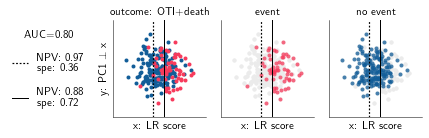

In [21]:
# Plot parameters
magnification = 2.8
plot_heatmap = False
plot_test = True
plot_immunoparalysis = False
alpha_bg = 1
mec = 'white'
ms = 8
mew = 0 #0.05
c_0 = dark_blue
c_1 = red_purp 
c_control = green
c_immunopar = orange
c_background = CF.lighten_color(grey_2, 0.6)
n_cols = 3
if 'FC' in model_name:
    n_cols += 1
if plot_immunoparalysis:
    n_cols += 1

# Set plot style    
CF.SetPlotParams(magnification=magnification*n_cols/4., ratio=float(2./(7.9*n_cols/4.)), fontsize=11, 
                 ylabelsize=9, xlabelsize=9, tex=True, axes_lines_w=0.5, lines_w=0.5, legendmarker=False)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False


# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=n_cols, sharey=True)


## Plot points
idx = 0
ax[idx].plot(X_1_0, X_2_0, ls=' ', marker='.', color=c_0, ms=ms, mew=mew, mec=mec, alpha=1.)
if 'FC' in model_name:
    if plot_test:
        ax[idx].plot(X_1_t, X_2_t, ls=' ', marker='.', color=c_control, ms=ms, mew=mew, mec=mec, alpha=1.)
ax[idx].plot(X_1_1, X_2_1, ls=' ', marker='.', color=c_1, ms=ms, mew=mew, mec=mec, alpha=1.)
ax[idx].axvline(threshold_0, color='black', alpha=1., ls='--', dashes=(1.5, 1.5), lw=1.2, 
                label='NPV: %.2f\nspe: %.2f' % (NPV_train_minNPVmodel, spe_train_minNPVmodel))
ax[idx].axvline(0, color='black', alpha=1., ls='-', lw=1.,
                label='NPV: %.2f\nspe: %.2f' % (NPV_train_model, spe_train_model)) 
ax[idx].set_xlim(x_1_min, x_1_max)
ax[idx].set_xticks(())
ax[idx].set_xlabel('x: LR score')
ax[idx].set_ylabel('y: PC1 $\perp$ x')
my_legend = ax[idx].legend(markerscale=1., scatterpoints=1, fontsize=11, handlelength=1.5, labelspacing=1.2, frameon=False, 
               loc='center right', bbox_to_anchor= (-.25, 0.5), ncol=1, borderaxespad=0)
my_legend.set_title('AUC=%.2f' % roc_train_model, prop = {'size':11}) #, 'style': 'italic'})
ax[idx].title.set_text('outcome: OTI+death')
ax[idx].grid(False)



idx = idx+1
ax[idx].plot(X_1_0, X_2_0, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
if plot_test:
    ax[idx].plot(X_1_t, X_2_t, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
ax[idx].plot(X_1_1, X_2_1, ls=' ', marker='.', color=c_1, ms=ms, mew=mew, mec=mec, alpha=0.75, label='Not survived')
ax[idx].axvline(threshold_0, color='black', alpha=1., ls='--', dashes=(1.5, 1.5), lw=1.2)
ax[idx].axvline(0, color='black', alpha=1., ls='-', lw=1.)
ax[idx].set_xlim(x_1_min, x_1_max)
ax[idx].set_xticks(())
ax[idx].set_xlabel('x: LR score')
#ax[idx].yaxis.set_visible(False)
#ax[idx].spines['left'].set_visible(False)
#ax[idx].legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), frameon=False) #legend(loc=0, frameon=False)
ax[idx].title.set_text('event')
ax[idx].grid(False)



idx = idx+1
if plot_test:
    ax[idx].plot(X_1_t, X_2_t, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
ax[idx].plot(X_1_1, X_2_1, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
ax[idx].plot(X_1_0, X_2_0, ls=' ', marker='.', color=c_0, ms=ms, mew=mew, mec=mec, alpha=0.75, label='Survived')
ax[idx].axvline(threshold_0, color='black', alpha=1., ls='--', dashes=(1.5, 1.5), lw=1.2)
ax[idx].axvline(0, color='black', alpha=1., ls='-', lw=1.)
ax[idx].set_xlim(x_1_min, x_1_max)
ax[idx].set_xticks(())
ax[idx].set_xlabel('x: LR score')
#ax[idx].yaxis.set_visible(False)
#ax[idx].spines['left'].set_visible(False)
#ax[idx].legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), frameon=False) #legend(loc=0, frameon=False)
ax[idx].title.set_text('no event')
ax[idx].grid(False)



if 'FC' in model_name:
    idx = idx+1
    ax[idx].plot(X_1_0, X_2_0, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
    ax[idx].plot(X_1_1, X_2_1, ls=' ', marker='.', color=c_background, ms=ms, mew=mew, mec=mec, alpha=alpha_bg)
    if plot_test:
        ax[idx].plot(X_1_t, X_2_t, ls=' ', marker='.', color=c_control, ms=ms, mew=mew, mec=mec, alpha=0.75, label='Control')
    ax[idx].axvline(threshold_0, color='black', alpha=1., ls='--', dashes=(1.5, 1.5), lw=1.2)
    ax[idx].axvline(0, color='black', alpha=1., ls='-', lw=1.)
    ax[idx].set_xlim(x_1_min, x_1_max)
    ax[idx].set_xticks(())
    ax[idx].set_xlabel('x: LR score')
    #ax[idx].yaxis.set_visible(False)
    #ax[idx].spines['left'].set_visible(False)
    #ax[idx].legend(loc='lower center', bbox_to_anchor=(0.5, 0.95), frameon=False) #legend(loc=0, frameon=False)
    ax[idx].title.set_text('outpatients')
    ax[idx].grid(False)
    

plt.ylim(x_2_min, x_2_max)
plt.yticks(())

filename = 'ScatterplotLR#%s' % (model_name)
filename = filename + exp_description + exp_multiv_description + '.pdf'
saving_str = path_figures + filename
plt.savefig(saving_str, bbox_inches='tight') #dpi=1000,

plt.show()

### Histogram

NPV: 0.97 
Spec.: 0.36
control: 15


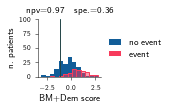

In [22]:
magnification = 0.85
ratio = 2.4/3.7
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15


fig, ax = plt.subplots()

value_pred = X2D_train[:, 0]
y_pred = np.zeros_like(y_train)
y_pred[value_pred>=threshold_0] = 1
y_pred_1 = 1 - y_pred
y_train_1 = 1 - y_train
npv_model = precision_score(y_train_1, y_pred_1)
spe_model = recall_score(y_train_1, y_pred_1)
print('NPV: %.2f'%npv_model, '\nSpec.: %.2f'%spe_model)
    
mask_class0 = y_train == 0
mask_class1 = y_train == 1
std = StandardScaler()
x = X2D_train[:,0]
x = std.fit_transform(x.reshape(-1, 1)).reshape(-1,)
x0 = x[mask_class0]
x1 = x[mask_class1]
xcontrol = X2D_test[:, 0]
xcontrol = std.transform(xcontrol.reshape(-1, 1)).reshape(-1,)
x_min = min([np.nanmin(x0), np.nanmin(x1), np.nanmin(xcontrol)])
x_max = max([np.nanmax(x0), np.nanmax(x1), np.nanmax(xcontrol)])
bins = np.linspace(x_min-0.2, x_max+0.2, 14)
print('control: %d' % (round(100*np.sum(xcontrol<threshold_0)/len(xcontrol))))

color = color_0
density = False
#ax.hist(x0, bins, alpha=.1, color=color, density=density, edgecolor='white', label='no event')
#ax.hist(x0, bins, alpha=1., edgecolor=color,density=density,facecolor='None')
ax.hist(x0, bins, alpha=1., color=color, density=density, label='no event')


if 'FC' in model_name:
        color = color_control
        #ax.hist(x1, bins, alpha=.1,  color=color, density=density, edgecolor=color, label='event')
        #ax.hist(x1, bins, alpha=1., edgecolor=color, density=density, facecolor='None')
        ax.hist(xcontrol, bins,
                alpha=0.3,
                color=color,
                density=density,
                label='control')
        ax.hist(xcontrol, bins,
                alpha=1., 
                edgecolor=color,
                density=density,
                facecolor='None')


color = color_1
#ax.hist(x1, bins, alpha=.1,  color=color, density=density, edgecolor=color, label='event')
#ax.hist(x1, bins, alpha=1., edgecolor=color, density=density, facecolor='None')
ax.hist(x1, bins,
        alpha=0.5,
        color=color,
        density=density,
        label='event')
ax.hist(x1, bins,
        alpha=1., 
        edgecolor=color,
        density=density,
        facecolor='None')

color_boundary = CF.lighten_color(grey_1, 0.6)
ax.axvline(threshold_0, ls='-', lw=0.9, color=electricblue)
ax.axvline(threshold_0, ls='-', lw=0.7, color='black') 

ax.title.set_text('npv=%.2f $\,\,\,$ spe.=%.2f'%(npv_model, spe_model))
ax.set_xlabel('%s score' % model_name)

ax.set_ylabel('n. patients')
if density:
    ax.set_ylabel('patients (density)')

if model_name=='FC+Dem':
        ax.set_yticks([0., 50., 100., 150])
        ax.set_ylim([0, 150])
if model_name=='BM+Dem':
        ax.set_ylim([0, 100])
if model_name=='CK+Dem':
       ax.set_ylim([0, 60])

leg = ax.legend(loc='center left', bbox_to_anchor=(0.98, 0.5), frameon=False) #legend(loc=0, frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_edgecolor('white')

#fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel('pc%d' % (comp1+1))
#plt.ylabel('pc%d' % (comp2+1))

filename = 'HistogramLR#%s' % (model_name)
filename = filename + exp_description + exp_multiv_description + '.pdf'
saving_str = path_figures + filename
plt.savefig(saving_str, bbox_inches='tight') #dpi=1000,
plt.show()